In [151]:
from pylab import *
from casadi import *
import time
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


In [152]:
#Site Data
df = pd.read_csv("data/calibration_25SitesModel.csv")
z̄ = (df['zbar_2017_25Sites'].to_numpy() )/normalization
n = len(z̄)

γ1_list  = df['gamma_25Sites'].to_numpy() -  df['gammaSD_25Sites'].to_numpy() 
γ2_list  = df['gamma_25Sites'].to_numpy() +  df['gammaSD_25Sites'].to_numpy() 
σ_list = df['gammaSD_25Sites'].to_numpy() *np.ones((1,n))
cov_list = σ_list * np.identity(n) *σ_list
mean = γ1_list/2 + γ2_list/2

z0_list = df['z_2017_25Sites'].to_numpy()
γ_post_list = ((γ1_list/2 + γ2_list/2)*np.ones((1,n))).T

θ_list  = df['theta_25Sites'].to_numpy()
Z0_list = z0_list/ normalization


γ_list_mean_posterior = ((γ1_list/2 + γ2_list/2)*np.ones((1,n))).T
γ_post_list_old = γ_post_list


gammadata = pd.DataFrame(γ_list_mean_posterior)

gammadata.to_csv('GammaData.csv', index=False)


In [153]:
import pandas as pd

df = pd.read_csv('amazon_data.dat', delimiter='\t')
# Process the data using the pandas DataFrame
df

,T,x_agg,z_agg
0,0,1.947026e+11,5.727942e+07
1,1,1.859395e+11,6.586853e+07
2,2,1.775708e+11,7.408871e+07
3,3,1.695788e+11,8.203418e+07
4,4,1.619465e+11,8.969940e+07
...,...,...,...
196,196,2.340840e+07,3.397517e+08
197,197,2.235484e+07,3.397517e+08
198,198,2.134871e+07,3.397517e+08
199,199,2.038786e+07,3.397517e+08


In [155]:
df = pd.read_csv('amazon_data_u.dat', delimiter='\t')
# Process the data using the pandas DataFrame
df

,T/R,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0.000014,0.000015,0.000010,0.000030,0.000044,0.000018,0.000020,0.000026,0.000054,...,0.000092,0.000080,0.000121,2.318518e-04,3.166713e-04,8.589111e+06,1.342988e-03,0.000131,0.000136,6.159228e-04
1,1,0.000010,0.000009,0.000010,0.000022,0.000040,0.000013,0.000016,0.000025,0.000059,...,0.000111,0.000106,0.000183,3.061926e-04,7.798311e-04,5.243681e+06,1.113642e+06,0.000235,716469.897459,1.146388e+06
2,2,0.000010,0.000008,0.000010,0.000021,0.000041,0.000011,0.000016,0.000026,0.000067,...,0.000125,0.000128,0.000269,4.788611e-04,2.000259e-03,1.466231e-03,7.945473e+06,0.000402,0.001843,1.698894e-02
3,3,0.000009,0.000009,0.000011,0.000023,0.000044,0.000011,0.000016,0.000026,0.000076,...,0.000170,0.000180,0.000605,1.691433e-03,4.409863e+06,6.450088e-04,3.255352e+06,0.001082,0.001144,8.114032e-03
4,4,0.000009,0.000009,0.000011,0.000025,0.000046,0.000010,0.000016,0.000027,0.000082,...,0.000207,0.000230,0.002967,4.293503e+06,1.488467e+06,3.372028e-04,2.444475e-03,0.003848,0.000533,8.266816e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,43.834246,43.903532,43.885208,43.903610,43.917212,43.898116,43.915655,43.820834,43.889717,...,43.939938,43.939275,43.890887,4.391541e+01,4.389912e+01,4.394664e+01,4.394559e+01,43.891263,43.883232,4.392870e+01
197,197,44.301551,44.345389,44.343447,44.260794,44.383607,44.388312,44.352381,44.204580,44.373116,...,44.368145,44.364945,44.327322,4.434100e+01,4.433028e+01,4.437620e+01,4.436379e+01,44.327966,44.312202,4.435532e+01
198,198,44.895148,44.912839,44.890037,44.561906,44.675231,44.725165,44.633068,44.637546,44.853788,...,44.921259,44.921575,44.899642,4.488329e+01,4.485544e+01,4.481956e+01,4.483676e+01,44.903268,44.806020,4.483110e+01
199,199,99.357972,90.844560,88.817282,21.770850,22.016852,98.081399,88.035877,21.952737,22.081917,...,22.359313,22.355709,22.184300,2.231098e+01,2.224214e+01,2.253275e+01,2.238987e+01,22.124390,22.017071,2.233250e+01


In [156]:
df = pd.read_csv('amazon_data_v.dat', delimiter='\t')
# Process the data using the pandas DataFrame
df

,T/R,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0.000064,0.000067,0.000038,0.000008,0.000007,0.000024,0.000016,0.000008,0.000006,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006
1,1,0.000091,0.000090,0.000046,0.000008,0.000007,0.000028,0.000018,0.000008,0.000006,...,0.000006,0.000006,0.000007,0.000006,0.000006,0.000006,0.000006,0.000006,0.000007,0.000007
2,2,0.000121,0.000113,0.000055,0.000009,0.000007,0.000031,0.000019,0.000009,0.000007,...,0.000006,0.000006,0.000007,0.000006,0.000006,0.000006,0.000006,0.000006,0.000007,0.000007
3,3,0.000177,0.000153,0.000067,0.000009,0.000008,0.000035,0.000021,0.000009,0.000007,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000008,0.000008
4,4,0.000250,0.000200,0.000079,0.000010,0.000008,0.000039,0.000023,0.000010,0.000007,...,0.000007,0.000007,0.000008,0.000007,0.000007,0.000007,0.000007,0.000007,0.000008,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,43.833790,43.903170,43.884807,43.904006,43.918159,43.897173,43.914834,43.821332,43.890348,...,43.940285,43.939602,43.891168,43.915680,43.899341,43.946800,43.945775,43.891542,43.883478,43.928927
197,197,44.300733,44.344761,44.342774,44.260113,44.383976,44.387581,44.352426,44.204753,44.373933,...,44.368756,44.365527,44.327805,44.341413,44.330600,44.376350,44.364003,44.328450,44.312512,44.355584
198,198,44.898747,44.915827,44.894085,44.523439,44.661289,44.735980,44.650001,44.564447,44.847143,...,44.917926,44.918505,44.897540,44.881806,44.854256,44.819104,44.835978,44.901078,44.805345,44.830462
199,199,21.850621,22.302140,22.428542,97.069527,95.559255,21.913118,22.406626,91.278944,95.000101,...,89.940640,89.970833,92.740196,90.474795,91.569090,86.838539,89.082443,93.843540,95.520674,90.013223


In [77]:
from gams import GamsWorkspace
if GamsWorkspace.api_major_rel_number<42:  # old API structure
    import gdxcc as gdx
    from gams import *
    import gamstransfer as gt
else:  # new API structure
    import gams.core.gdx as gdx
    from gams.control import *
    import gams.transfer as gt

In [78]:
from gams import *
import os
import sys


def main():
    cwd = os.getcwd() # get current working directory

    if not os.path.isfile(os.path.join(cwd, "amazon_25sites.gms")):
        with open(os.path.join(cwd, "amazon_25sites.gms"), "w") as text_file:
            text_file.write(get_model_text())

    ws = GamsWorkspace(system_directory=r"C:\GAMS\43", working_directory=cwd)
    t1 = ws.add_job_from_file("amazon_25sites.gms")
    t1.run()


if __name__ == "__main__":
    try:
        main()
    except GamsException as e:
        print("An error occurred: " + str(e))



In [79]:
normalization = 1e9
δ  = 0.02
α  = 0.045007414
κ  = 2.094215255
pf = 20.76
ζ  = 1.66e-4 * normalization 
p2 =  44.75
ξ = 15

In [4]:

def normal(z, μ, Σ):
    """
    The density function of multivariate normal distribution.

    Parameters
    ---------------
    z: ndarray(float, dim=2)
        random vector, N by 1
    μ: ndarray(float, dim=1 or 2)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1
    """


    N = 10

    temp2 = -.5 * (z - μ).T @ np.linalg.inv(Σ) @ (z - μ)

    return  temp2

In [5]:
simulation = 1000_00
γ_vec  = np.zeros((10,simulation+1))
γ_vec[:,0]= ((γ1_list/2 + γ2_list/2)).T

In [6]:
error = 1e9
tol = 0.02

In [7]:
leng=200
arr = np.cumsum(
                   np.triu(
                     np.ones((leng, leng))
                   ), axis=1)

Bdym=(1-α)**(arr-1)
Bdym[Bdym>1] = 0 
Bdym = Bdym.T

Adym = (np.linspace(1,200,200)*np.ones((1,200))).T

# Explaining the Code


1. Optimization Phase: For a given $\tilde \gamma$ we solve the problem, using some sort of optimization algorithm (IPOPT in our case),  

\begin{equation}
      \left\{ \int_0^\infty \exp(-\delta t) \left[-P^e  \left (\kappa\sum_{i=1}^I Z^i_t- \sum_{i=1}^I \dot X^i_t \right)+  P^a_t  \sum_i \theta^i Z^i_t-\frac \zeta 2 \left (\sum_i U_t^i + V_t^i \right)^2 \right ] dt\right\} 
\end{equation}

\begin{equation} \label{eq:z}
\dot Z_t^i = U_t^i - V_t^i . 
\end{equation}

\begin{equation} \label{eq:x}
{\dot X}_t^i  = - \tilde \gamma^i U^i_t - \alpha \left[ X_t^i - \tilde \gamma^i  \left( {{\bar z}^i - Z_t^i }  \right) \right] 
\end{equation}

$$
X_0^i = \tilde \gamma^i * C
$$

where $C$ is some constant. 

2. MC phase: The algorithm for this part is the standard Metropolis-Hastings Algorirthm. The only thing that is a bit troublesome to deal with is the formulation of our likelihood which is $g$. 

    1. We are given $\gamma^*$ via the MHMC algorithm. 
    2. Use $U_t^i$ and $V_t^i$ to evaluate the objective function under $\gamma^*$. 
    3. Form the Likelihood $g$

\begin{equation}\label{min_solution}
g^* = \exp\left[ - {\frac 1 \xi } \left\{ \int_0^\infty \exp(-\delta t) \left[-P^e  \left (\kappa\sum_{i=1}^I Z^i_t- \sum_{i=1}^I \dot X^i_t \right)+  P^a_t  \sum_i \theta^i Z^i_t-\frac \zeta 2 \left (\sum_i U_t^i + V_t^i \right)^2 \right ] dt\right\} \right]
\end{equation} 
    
    



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

prepare simulations
Simulation 0
Execution time: 0.10128021240234375 seconds
Simulation 10000
Execution time: 117.08608388900757 seconds
Simulation 20000
Execution time: 89.94240212440491 seconds
Simulation 30000
Execution time: 91.4860029220581 seconds
Simulation 40000
Execution time: 89.56886982917786 seconds
Simulation 50000
Execution time: 99.57113099098206 seconds
Simulation 60000
Execution time: 90.56123304367065 seconds
Simulation 70000
Execution time: 93.62973093986511 seconds
Simulation 80000
Execution time: 92.9725251197815 seconds
Simulation 90000
Execution time: 105.612233877182 seconds
0.1590

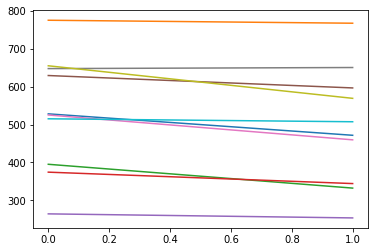

prepare simulations
Simulation 0
Execution time: 0.11309504508972168 seconds
Simulation 10000
Execution time: 91.23633980751038 seconds
Simulation 20000
Execution time: 89.73035907745361 seconds
Simulation 30000
Execution time: 96.70290112495422 seconds
Simulation 40000
Execution time: 106.67641091346741 seconds
Simulation 50000
Execution time: 80.6873881816864 seconds
Simulation 60000
Execution time: 97.89272022247314 seconds
Simulation 70000
Execution time: 106.94846200942993 seconds
Simulation 80000
Execution time: 96.29766702651978 seconds
Simulation 90000
Execution time: 88.6825578212738 seconds
0.1371053231521479


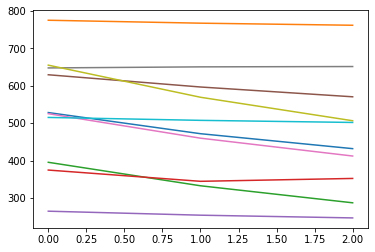

prepare simulations
Simulation 0
Execution time: 0.11081600189208984 seconds
Simulation 10000
Execution time: 104.33894777297974 seconds
Simulation 20000
Execution time: 75.98618912696838 seconds
Simulation 30000
Execution time: 74.95817589759827 seconds
Simulation 40000
Execution time: 74.8094310760498 seconds
Simulation 50000
Execution time: 75.17958188056946 seconds
Simulation 60000
Execution time: 76.4900369644165 seconds
Simulation 70000
Execution time: 75.10362696647644 seconds
Simulation 80000
Execution time: 76.54907488822937 seconds
Simulation 90000
Execution time: 76.14897298812866 seconds
0.11739759469987346


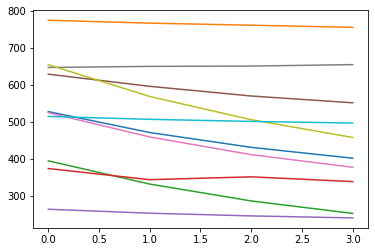

prepare simulations
Simulation 0
Execution time: 0.08529806137084961 seconds
Simulation 10000
Execution time: 76.1955714225769 seconds
Simulation 20000
Execution time: 96.12363123893738 seconds
Simulation 30000
Execution time: 97.96117901802063 seconds
Simulation 40000
Execution time: 76.47227025032043 seconds
Simulation 50000
Execution time: 89.14515089988708 seconds
Simulation 60000
Execution time: 102.75946998596191 seconds
Simulation 70000
Execution time: 92.37800097465515 seconds
Simulation 80000
Execution time: 101.55893778800964 seconds
Simulation 90000
Execution time: 83.37301087379456 seconds
0.09743641296003071


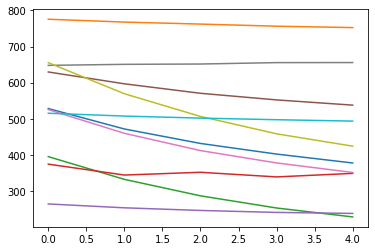

prepare simulations
Simulation 0
Execution time: 0.11960697174072266 seconds
Simulation 10000
Execution time: 113.78605103492737 seconds
Simulation 20000
Execution time: 83.60297203063965 seconds
Simulation 30000
Execution time: 74.73763990402222 seconds
Simulation 40000
Execution time: 77.07306480407715 seconds
Simulation 50000
Execution time: 74.93089818954468 seconds
Simulation 60000
Execution time: 76.58750414848328 seconds
Simulation 70000
Execution time: 83.66920709609985 seconds
Simulation 80000
Execution time: 86.00603294372559 seconds
Simulation 90000
Execution time: 82.75419068336487 seconds
0.06324882413106091


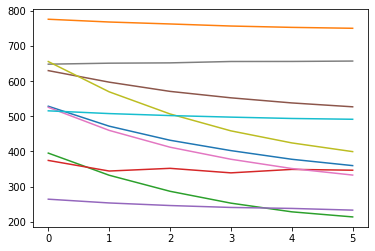

prepare simulations
Simulation 0
Execution time: 0.09595799446105957 seconds
Simulation 10000
Execution time: 96.09477496147156 seconds
Simulation 20000
Execution time: 82.00614404678345 seconds
Simulation 30000
Execution time: 81.14308834075928 seconds
Simulation 40000
Execution time: 85.3785719871521 seconds
Simulation 50000
Execution time: 79.99589014053345 seconds
Simulation 60000
Execution time: 96.60363006591797 seconds
Simulation 70000
Execution time: 81.56227040290833 seconds
Simulation 80000
Execution time: 91.6618299484253 seconds
Simulation 90000
Execution time: 85.58282494544983 seconds
0.04491146491433964


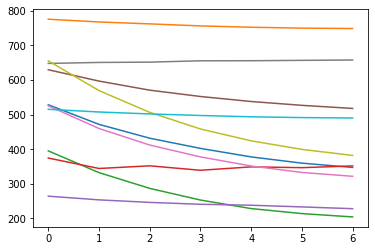

prepare simulations
Simulation 0
Execution time: 0.0984959602355957 seconds
Simulation 10000
Execution time: 81.10678601264954 seconds
Simulation 20000
Execution time: 84.92325687408447 seconds
Simulation 30000
Execution time: 78.41909313201904 seconds
Simulation 40000
Execution time: 75.69277715682983 seconds
Simulation 50000
Execution time: 79.67510080337524 seconds
Simulation 60000
Execution time: 79.44790887832642 seconds
Simulation 70000
Execution time: 80.11849403381348 seconds
Simulation 80000
Execution time: 87.70923614501953 seconds
Simulation 90000
Execution time: 87.95807909965515 seconds
0.03800426501373413


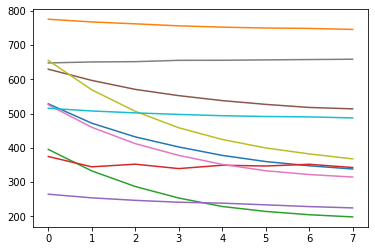

prepare simulations
Simulation 0
Execution time: 0.11214280128479004 seconds
Simulation 10000
Execution time: 84.388338804245 seconds
Simulation 20000
Execution time: 91.89720702171326 seconds
Simulation 30000
Execution time: 79.07580995559692 seconds
Simulation 40000
Execution time: 76.64986634254456 seconds
Simulation 50000
Execution time: 76.70691084861755 seconds
Simulation 60000
Execution time: 78.8776798248291 seconds
Simulation 70000
Execution time: 79.40937805175781 seconds
Simulation 80000
Execution time: 75.36662602424622 seconds
Simulation 90000
Execution time: 92.24484992027283 seconds
0.0286982463564667


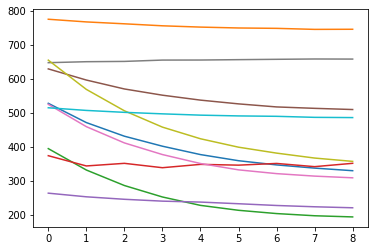

prepare simulations
Simulation 0
Execution time: 0.09751701354980469 seconds
Simulation 10000
Execution time: 79.53134179115295 seconds
Simulation 20000
Execution time: 82.60811424255371 seconds
Simulation 30000
Execution time: 103.12301898002625 seconds
Simulation 40000
Execution time: 92.27276992797852 seconds
Simulation 50000
Execution time: 104.50267791748047 seconds
Simulation 60000
Execution time: 78.46777391433716 seconds
Simulation 70000
Execution time: 100.63060021400452 seconds
Simulation 80000
Execution time: 93.40950393676758 seconds
Simulation 90000
Execution time: 92.70967698097229 seconds
0.026882768483609844


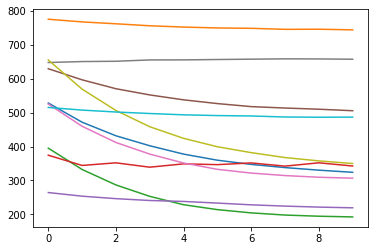

prepare simulations
Simulation 0
Execution time: 0.0877828598022461 seconds
Simulation 10000
Execution time: 87.72686576843262 seconds
Simulation 20000
Execution time: 86.9622368812561 seconds
Simulation 30000
Execution time: 108.75945591926575 seconds
Simulation 40000
Execution time: 73.41059684753418 seconds
Simulation 50000
Execution time: 88.57038903236389 seconds
Simulation 60000
Execution time: 125.46764898300171 seconds
Simulation 70000
Execution time: 111.64167618751526 seconds
Simulation 80000
Execution time: 91.97801184654236 seconds
Simulation 90000
Execution time: 104.65940976142883 seconds
0.024856599504321716


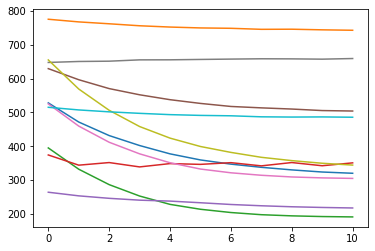

prepare simulations
Simulation 0
Execution time: 0.15089678764343262 seconds
Simulation 10000
Execution time: 126.5301468372345 seconds
Simulation 20000
Execution time: 112.32163786888123 seconds
Simulation 30000
Execution time: 128.9671230316162 seconds
Simulation 40000
Execution time: 103.1454770565033 seconds
Simulation 50000
Execution time: 119.96942114830017 seconds
Simulation 60000
Execution time: 94.13626599311829 seconds
Simulation 70000
Execution time: 109.78523683547974 seconds
Simulation 80000
Execution time: 100.66659379005432 seconds
Simulation 90000
Execution time: 85.46276092529297 seconds
0.017063334730133772


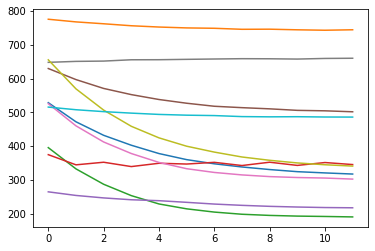

In [8]:
era = 0
while error > tol: 
    
    x0_list = γ_post_list.T * df['forestArea_2017_ha_25Sites'].to_numpy()
    X0_list = x0_list/ normalization
    #Construct Matrix A
    Az = np.zeros((n, n+2))
    Ax = np.zeros((1, n+2))

    Ax[0:1,0:n-0] = -α *γ_post_list[0:n].T
    Ax[0, -1] = np.sum(α*γ_post_list.T * z̄)
    Ax[0,-2]  = -α

    A  = np.concatenate((Az, Ax, np.zeros((1, n+2))), axis=0)
    
    # Construct Matrix B
    Bz = np.identity((n))
    Bx = (np.zeros((1,n)))
    B  = np.concatenate((Bz, Bx,  np.zeros((1, n))), axis=0)
    
    # Construct Matrix B
    Dz =   np.zeros((n,n))
    Dx = -(np.ones((1,n))*γ_post_list[0:n].T)

    D  = np.concatenate((Dz, Dx, np.zeros((1, n))), axis=0)
    
    T   = 200
    N   = T

    dt = T/N
    Y = MX.sym('Y'  ,n + 2) 
    up = MX.sym('up',n) 
    um = MX.sym('um',n) 

    rhs = (sparsify(A)@Y + sparsify(B)@(up-um) + sparsify(D)@(up))*dt + Y
    f = Function('f', [Y, um, up],[rhs])

    import math
    ds_vect = np.zeros((N+1,1))
    for i in range(N+1):
        ds_vect[i]=math.exp(-δ*i*dt)   
        
    opti = casadi.Opti()

    # Decision variables for states

    X = opti.variable(n+2 ,N+1)
    # Aliases for states

    Up = opti.variable(n,N)
    Um = opti.variable(n,N)
    Ua = opti.variable(1,N)
    
    # 1.2: Parameter for initial state
    ic = opti.parameter(n+2-0)

    # Gap-closing shooting constraints
    for k in range(N):
        opti.subject_to(X[:,k+1]==f(X[:,k],Um[:,k], Up[:,k]))

    # Initial and terminal constraints
    opti.subject_to(X[:,0] == ic)
    opti.subject_to(opti.bounded(0,X[0:n,:],z̄[0:n]))
    # Objective: regularization of controls
    # 1.1: added regularization
    for k in range(n-0):
        opti.subject_to(opti.bounded(0,Um[k,:],inf))
        opti.subject_to(opti.bounded(0,Up[k,:],inf))

    opti.subject_to(Ua == sum1(Up+Um)**2 )

    opti.minimize( sum2(ds_vect[0:N,:].T*(Ua* ζ/2 ))
                  - sum2(ds_vect[0:N,:].T*(pf*X[-2,1:] - pf*X[-2,0:-1]  ))
                  - sum2(ds_vect.T*sum1((p2*θ_list - pf*κ )*X[0:n-0,:] )))

    # solve optimization problem 
    options = dict()
    options["print_time"] = False
    options["expand"]     = True
    options["ipopt"]      = {
                        'print_level': 0,
                        'fast_step_computation':            'yes',
                        'mu_allow_fast_monotone_decrease':  'yes',
                        'warm_start_init_point':            'yes',
                            }
    opti.solver('ipopt',options)

    t1 = time.time()
    opti.set_value(ic,vertcat(Z0_list,np.sum(X0_list),1))
    sol = opti.solve()
    
    
    trace = {"γ":np.zeros((simulation,n))}
    θ_list_comp = θ_list * np.ones((1,n))
    
    objective_value = -(sum2(ds_vect[0:T,:].T*(sol.value(Ua)* ζ/2 ))
                      - sum2(ds_vect[0:T,:].T*(pf*sol.value(X)[-2,1:] 
                                               - pf*sol.value(X)[-2,0:-1]  ))
                      - sum2(ds_vect.T*sum1((p2*θ_list_comp.T - pf*κ )*sol.value(X)[0:n,:] )))
    
    fγ̄ =   -.5 * (γ_post_list - γ_list_mean_posterior).T @ np.linalg.inv(cov_list) @ (γ_post_list - γ_list_mean_posterior)
    N_star_old = -1/ξ * objective_value  + fγ̄ 
    
    print('prepare simulations')
    st = time.time()
    innov = stats.multivariate_normal(np.zeros_like(mean), cov_list).rvs(size=simulation)
    u = stats.uniform(0, 1).rvs(simulation)
    
    for episode in range(simulation):
        γ_list_prime = ((γ_post_list.T + innov[episode,:])*np.ones((1,10))).T
        while np.sum(γ_list_prime <0)>0 :
            innov_temp = stats.multivariate_normal(np.zeros_like(mean), cov_list).rvs(size=1)
            γ_list_prime = ((γ_post_list.T + innov_temp)*np.ones((1,10))).T
            
        x0_list = γ_list_prime.T * df['forestArea_2017_ha_25Sites'].to_numpy()
        X0_list = x0_list/ normalization
        
        θ_list_comp = θ_list * np.ones((1,n))
        z̄_comp = z̄ * np.ones((1,n))
        
        X_dym_list = np.zeros((1,T+1))
        X_zero_list = np.sum(X0_list)*np.ones((200,1))
        X_dym_list[:,0] = np.sum(X0_list)
        ω =   (γ_list_prime.T@(α*z̄_comp.T- α*sol.value(X)[0:n,:-1]) -γ_list_prime.T@sol.value(Up))
        X_dym_list[:,1:] =( (((1-α)**Adym))*X_zero_list  + (Bdym@ω.T )  ).T

        objective_value = -(sum2(ds_vect[0:T,:].T*(sol.value(Ua)* ζ/2 ))
                      - sum2(ds_vect[0:T,:].T*(pf*X_dym_list[:,1:] 
                                               - pf*X_dym_list[:,0:-1]  ))
                      - sum2(ds_vect.T*sum1((p2*θ_list_comp.T - pf*κ )*sol.value(X)[0:n,:] )))
        
        fγ̄ =   -.5 * (γ_list_prime - γ_list_mean_posterior).T @ np.linalg.inv(cov_list) @ (γ_list_prime - γ_list_mean_posterior)
        N_star = -1/ξ * objective_value    + fγ̄
    
        RC_pre = np.array(N_star-N_star_old)
        RC = np.nanmin(np.array([0, RC_pre[0,0]]))
        if np.log(u[episode]) < RC : 
            N_star_old = N_star
            γ_post_list = γ_list_prime
            
            
        if episode % 10000 == 0:
            et = time.time()
            print(f'Simulation {episode}')
            elapsed_time = et - st
            print('Execution time:', elapsed_time, 'seconds')
            st = time.time()

        trace["γ"][episode:episode+1] = γ_post_list.T
    γ_post_list = (np.sum(trace["γ"], axis=0 )/simulation *np.ones((1,10))).T/4 + γ_post_list_old*3/4
    error =np.max(abs(γ_post_list_old-γ_post_list)/γ_post_list_old)
    print(error)
    γ_post_list_old = γ_post_list
    γ_vec[:, era+1:era+2] = γ_post_list
    Posterior = trace["γ"]
    plt.plot(γ_vec[:,:era+2].T)
    plt.show()

    era = era+1

In [9]:
np.save(f'ξ_{ξ}_Posterior', Posterior)

In [10]:
mc = simulation*10

In [11]:
    γ_list_mc = stats.multivariate_normal(mean, cov_list).rvs(size=mc)
    γ_list_mc = γ_list_mc[(γ_list_mc >= 0).all(axis=1)]
    while np.shape(γ_list_mc)[0] < mc:
        γ_list_mc_temp = stats.multivariate_normal(mean, cov_list).rvs(size = mc - np.shape(γ_list_mc)[0])
        if np.size(γ_list_mc_temp)> 10:
            γ_list_mc_temp = γ_list_mc_temp[(γ_list_mc_temp >= 0).all(axis=1)]
        else:
            γ_list_mc_temp = (γ_list_mc_temp*np.ones((1,10)))
        γ_list_mc = np.concatenate((γ_list_mc, γ_list_mc_temp), axis=0)

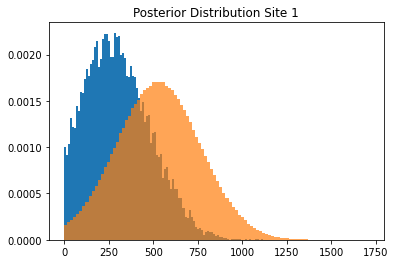

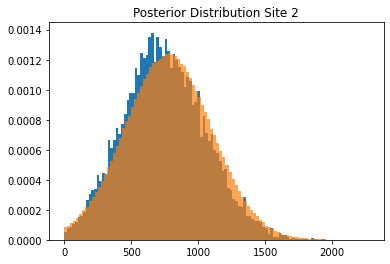

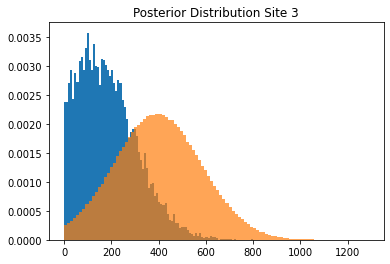

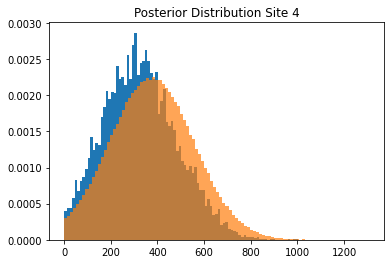

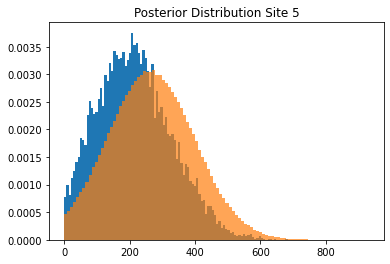

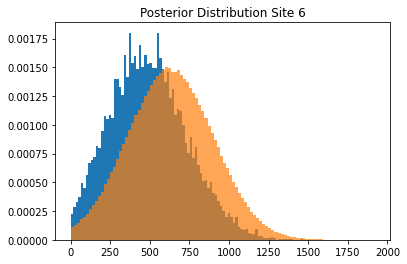

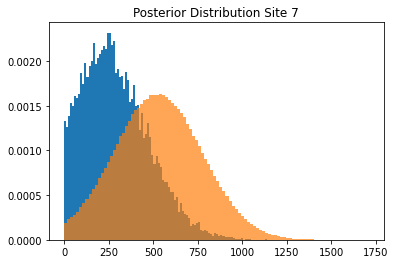

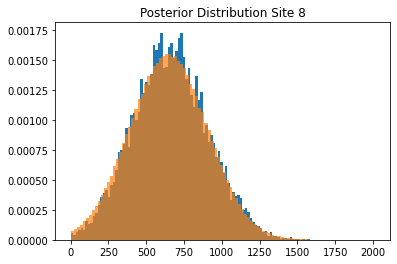

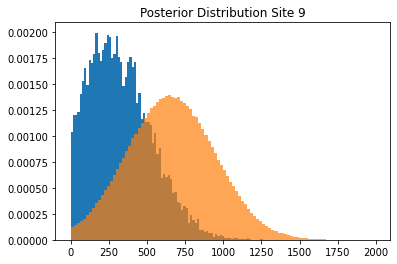

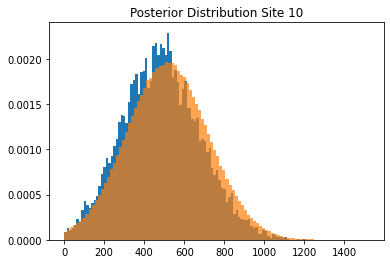

In [12]:
for i in range(10):
    plt.hist(Posterior[:,i], bins = 100, density=True)
    plt.hist(γ_list_mc[:,i], bins = 100, alpha=0.7, density=True)

    plt.title(f'Posterior Distribution Site {i+1}')
    plt.show()